In [1]:
# IMPORTING ALL NECESSARY LIBRARIES
import os
!pip install keras
!pip install tensorflow
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

2022-11-28 21:18:57.604181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
BATCH_SIZE = 64
# CREATING AN IMAGE GENERATOR FOR PREPROCESSING DATA. THIS CAN BE SEEN AS DATA PIPELINE THAT FEEDS DATA TO THE MODEL
# THIS IS IMAGE GENERATOR FOR TRAINING DATASET
train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing
# THIS IS IMAGE GENERATOR FOR TESTING DATASET
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing
# GETTING THE DATASET
download_dir = Path('Train_Test_Folder')

In [3]:
# GETTING THE TRAIN/TEST SETS
train_data_dir = download_dir/'train'
test_data_dir = download_dir/'test'
# GETTING ALL LABELS
class_subset = sorted(os.listdir(download_dir/'train'))
# CREATING TRAINING DATA FLOW TO FEED THE DL MODEL TRAINING DATA
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)
# CREATING TRAINING DATA FLOW TO FEED THE DL MODEL VALIDATING DATA

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)
# CREATING TRAINING DATA FLOW TO FEED THE DL MODEL TESTING DATA

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 1137 images belonging to 47 classes.
Found 174 images belonging to 47 classes.
Found 590 images belonging to 47 classes.


In [4]:
# CREATING VGG16 MODEL
# WE USE VGG16 MODEL FOR FEATURES EXTRACTION AND CONNECT THE END WITH MULTIPLE FC (FULLY CONNECTED) LAYERS FOR CLASIFICATION
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [9]:
# DEFINING THE INPUT SHAPE (IMAGE SIZE)
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=47

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [10]:
# CREATING CHECKPOINT WHEN TRAINING THE DL MODEL
!pip install livelossplot
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

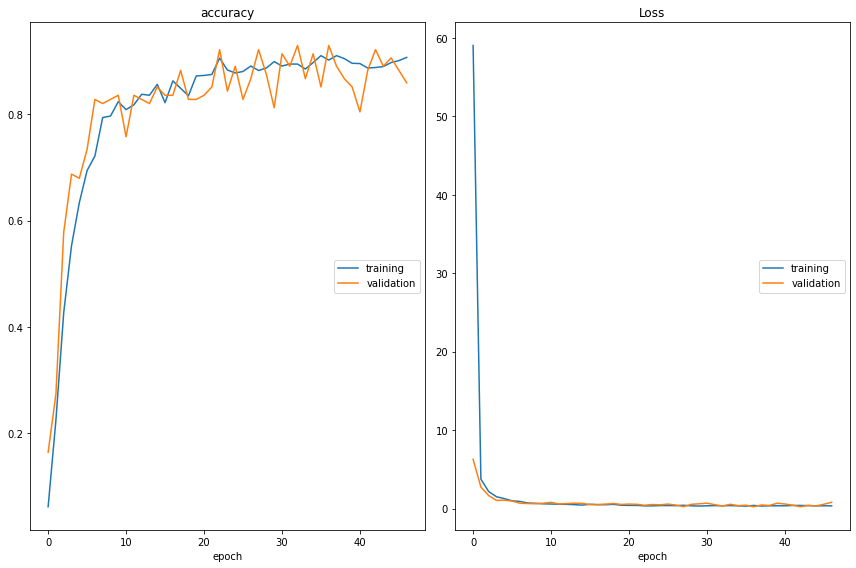

accuracy
	training         	 (min:    0.062, max:    0.911, cur:    0.907)
	validation       	 (min:    0.164, max:    0.930, cur:    0.859)
Loss
	training         	 (min:    0.317, max:   59.025, cur:    0.347)
	validation       	 (min:    0.236, max:    6.279, cur:    0.806)
17/17 [==============================] - 281s 16s/step - loss: 0.3466 - accuracy: 0.9072 - val_loss: 0.8064 - val_accuracy: 0.8594
CPU times: user 13h 46s, sys: 36min 24s, total: 13h 37min 11s
Wall time: 5h 49min 12s


In [11]:
%%time 
# PLOTTING THE ACCURACY AND LOSS
vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [12]:
# Generate predictions
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

590/590 [==============================] - 150s 254ms/step


In [13]:
# GETTING THE MODEL ACCURACY ON TEST SET
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 79.83%
